# CNN sa balansiranim train_validation skupom

In [2]:
import cv2
import glob
import fnmatch
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import random

In [3]:
from keras import utils
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.optimizers import Adam
from keras.metrics import AUC

### Učitavanje  putanja slika

Za učitavanje putanja do slika sa kojima radimo koristimo funkciju ***glob***. Kao argumente prosleđujemo putanje
(sa wild card karakterima koji zamenjuju bilo koje uzastopne karaktere), i parametar *recursive* koji, kada je postavljen
na *True*, omogućava da se pretrga vrši po svim direktorijumima i poddirektorijumima.

In [4]:
imagePatches = glob.glob('C:/Users/pc/Desktop/data/**/*.png', recursive=True)

Odlučili smo da radimo sa skupom od 40 000 slika.

In [5]:
imagePatches = imagePatches[:40000]

Koristimo činjenicu da svaka slika u svojoj putanji ima naznačenu klasu kojoj pripada, "class0" za 0, i "class1" za 1.

In [6]:
patternZero = '*class0.png'
patternOne = '*class1.png'

Funkcija ***fnmatch.filter*** pronalazi sve putanje koje u sebi imaju šablon koji prosleđujemo kao drugi argument. Pomoću nje delimo naše putanje u dve grupe, u zavisnosti od klase.

In [7]:
classZero = fnmatch.filter(imagePatches, patternZero) 
classOne = fnmatch.filter(imagePatches, patternOne)

Broj instanci negativne (invazivni duktalni karcinom nije detektovan) i pozitivne (invazivni duktalni karcinom je detektovan) klase:

In [8]:
print('IDC(-): {}, IDC(+): {}' .format(len(classZero), len(classOne)))

IDC(-): 30753, IDC(+): 9247


Pravimo vektor ciljnih promenljivih koji će nam biti potreban za stratifikaciju prilikom deljenja na trening i test skup.

In [9]:
y = np.zeros(len(imagePatches))
for i in range(len(imagePatches)):
    if imagePatches[i] in classOne:
        y[i] = 1

In [10]:
y = y.astype('int64')
np.bincount(y)

array([30753,  9247], dtype=int64)

### Podela podataka na train, validacioni i test skup

In [11]:
train_val_paths,test_paths,y_train_val,y_test = model_selection.train_test_split(imagePatches, y, test_size = 0.33, random_state = 42, stratify = y)

In [12]:
print('train_validation_size: {}, test_size: {} ' .format(len(train_val_paths), len(test_paths)))

train_validation_size: 26800, test_size: 13200 


In [13]:
n = np.bincount(y_train_val)
print('TrainVal skup: IDC(-): {}, IDC(+): {}' .format(n[0], n[1]))

TrainVal skup: IDC(-): 20605, IDC(+): 6195


In [14]:
n = np.bincount(y_test)
print('Test skup: IDC(-): {}, IDC(+): {}' .format(n[0], n[1]))

Test skup: IDC(-): 10148, IDC(+): 3052


Dimenzije pojedinačne slike:

In [15]:
width = 50
height = 50

Prvo učitavamo slike za test skup.

In [16]:
X_test = []

for i in range(len(test_paths)):
    img = cv2.resize(cv2.imread(test_paths[i]), (width, height), interpolation=cv2.INTER_CUBIC)
    X_test.append(img)
    
X_test = np.array(X_test)

In [17]:
X_test.shape

(13200, 50, 50, 3)

### Nebalansiranost train_val skupa

Train_validation skup je nebalansiran:

In [18]:
n = np.bincount(y_train_val)
print('Train_Validation skup: IDC(-): {}, IDC(+): {}' .format(n[0], n[1]))

Train_Validation skup: IDC(-): 20605, IDC(+): 6195


Iz train_validation skupa izdvajamo putanje do instanci pozitivne i negativne klase:

In [19]:
classZeroTrainVal = fnmatch.filter(train_val_paths, patternZero) 
classOneTrainVal = fnmatch.filter(train_val_paths, patternOne)

Utvrđujemo kolika je razlika između broja instanci negativne i pozitivne klase. Izdvajamo onoliko putanja do pozitivnih instanci kolika je dobijena razlika (broj n). Te putanje smeštamo u skup "additional_paths". Izdvajanje mora biti sa ponavljanjem, jer razlika između kardinalnosti klasa može biti veća od kardinalnosti manjinske klase.

In [20]:
n = len(classZeroTrainVal) - len(classOneTrainVal)
index = np.random.randint(0, len(classOneTrainVal), n)
classOneTrainVal = np.array(classOneTrainVal)
additional_paths = classOneTrainVal[index] 

In [21]:
X_train_val = []
y_train_val = list(y_train_val)

Učitavamo slike iz nebalansiranog train_validation skupa:

In [22]:
for i in range(len(train_val_paths)):
    img = cv2.resize(cv2.imread(train_val_paths[i]), (width, height), interpolation=cv2.INTER_CUBIC)
    X_train_val.append(img)

Nakon toga, za svaku putanju iz additional_paths učitavamo sliku koju dodajemo u train_validation skup, pri tom primenjujući transformacije kao što su rotacija i prevrtanje (flip). Transformaciju koju primenjujemo biramo na slučajan način za svaku sliku, korišćenjem funkcije ***random.randint*** kojom biramo indeks iz liste transformacija:

In [23]:
rotate = [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
flip = [0, 1, -1]

for i in range(len(additional_paths)):
    img = cv2.resize(cv2.imread(additional_paths[i]), (width, height), interpolation=cv2.INTER_CUBIC)
    r = np.int(np.random.randint(0,3,1))
    f = np.int(np.random.randint(0,3,1))
    img = cv2.rotate(img, rotate[r])
    img = cv2.flip(img, flip[f])
    X_train_val.append(img)
    y_train_val.append(1)

Dodatno mešamo slike, da ne bismo na jednom mestu imali veliki broj instanci pozitivne klase koje smo naknadno dodali:

In [24]:
X_train_val = np.array(X_train_val)
index =  random.sample(list(np.arange(len(X_train_val))), k = len(X_train_val))
X_train_val = X_train_val[index]
y_train_val = np.array(y_train_val)
y_train_val = y_train_val[index]

In [25]:
X_train_val.shape

(41210, 50, 50, 3)

Dobili smo balansiran skup.

In [26]:
np.bincount(y_train_val)

array([20605, 20605], dtype=int64)

##### Podela train_validation skupa

In [27]:
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, stratify = y_train_val)

In [28]:
print('train_size: {}, val_size: {}' .format(len(X_train),len(X_val)))

train_size: 32968, val_size: 8242


### Normalizacija

Svodimo vrednosti svakog piksela u opseg [0,1]

In [29]:
X_train = X_train.astype('float32')
X_train = X_train/255

In [30]:
X_val= X_val.astype('float32')
X_val = X_val/255

In [31]:
X_test = X_test.astype('float32')
X_test = X_test/255

### Kreiranje i treniranje mreže 

In [32]:
input_shape = (50,50,3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 1e-5), metrics = [AUC(name = 'auc')])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [33]:
batch_size = 64
epochs = 30
history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_val, y_val))

Epoch 1/30
516/516 [==============================] - 94s 182ms/step - loss: 0.6165 - auc: 0.7869 - val_loss: 0.5334 - val_auc: 0.8499
Epoch 2/30
516/516 [==============================] - 95s 185ms/step - loss: 0.4916 - auc: 0.8582 - val_loss: 0.4719 - val_auc: 0.8638
Epoch 3/30
516/516 [==============================] - 95s 184ms/step - loss: 0.4565 - auc: 0.8708 - val_loss: 0.4520 - val_auc: 0.8719 - loss
Epoch 4/30
516/516 [==============================] - 96s 186ms/step - loss: 0.4459 - auc: 0.8754 - val_loss: 0.4455 - val_auc: 0.8757
Epoch 5/30
516/516 [==============================] - 95s 185ms/step - loss: 0.4389 - auc: 0.8793 - val_loss: 0.4396 - val_auc: 0.8784
Epoch 6/30
516/516 [==============================] - 104s 201ms/step - loss: 0.4361 - auc: 0.8806 - val_loss: 0.4369 - val_auc: 0.8802
Epoch 7/30
516/516 [==============================] - 108s 210ms/step - loss: 0.4331 - auc: 0.8820 - val_loss: 0.4352 - val_auc: 0.8816
Epoch 8/30
516/516 [==========================

In [34]:
model.metrics_names

['loss', 'auc']

In [35]:
def plot(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    
    epochs = history.epoch
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    plt.title('LOSS')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(epochs,loss,c='red',label='training')
    plt.plot(epochs,validation_loss,c='blue',label='validation')
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    
    acc = history.history['auc']
    acc_val = history.history['val_auc']
    plt.title('AUC')
    plt.xlabel('epochs')
    plt.ylabel('AUC')
    plt.plot(epochs,acc,c='red',label='training')
    plt.plot(epochs,acc_val,c='blue',label='validation')
    plt.legend(loc='best')
    
    plt.show()

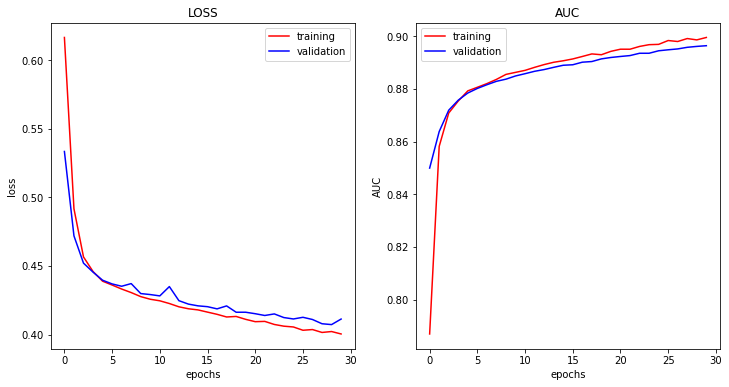

In [36]:
plot(history)

### Evaluacija mreže

Datu mrežu ćemo trenirati nad čitavim train_validation skupom koji je balansiran i evaluirati je.

In [37]:
X_train_val = X_train_val/255

In [38]:
input_shape = (50,50,3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 1e-5), metrics = [AUC(name = 'auc')])

In [39]:
model.fit(X_train_val, y_train_val, epochs = epochs, batch_size = batch_size, verbose = 0)

In [40]:
score_test = model.evaluate(X_test,y_test, verbose = 0, batch_size = batch_size)

ERROR! Session/line number was not unique in database. History logging moved to new session 431


In [41]:
print('loss_test:{:.2f}, auc_score_test: {:.2f}' .format(score_test[0],score_test[1]))

loss_test:0.37, auc_score_test: 0.90


In [42]:
y_pred_prob = model.predict(X_test)

In [43]:
y_pred = np.zeros(len(X_test))
for i in range(len(X_test)):
    if(y_pred_prob[i]>=0.5):
        y_pred[i] = 1

In [44]:
m = confusion_matrix(y_test,y_pred)
print(m)

[[8697 1451]
 [ 626 2426]]


In [45]:
r = classification_report(y_test,y_pred)
print(r)

              precision    recall  f1-score   support

           0       0.93      0.86      0.89     10148
           1       0.63      0.79      0.70      3052

    accuracy                           0.84     13200
   macro avg       0.78      0.83      0.80     13200
weighted avg       0.86      0.84      0.85     13200



In [46]:
accuracy = metrics.accuracy_score(y_test,y_pred)
print('accuracy_score: {:.2f}' .format(accuracy))

accuracy_score: 0.84


In [47]:
f1 = metrics.f1_score(y_test,y_pred)
print('f1_score: {:.2f}' .format(f1))

f1_score: 0.70


In [48]:
auc = metrics.roc_auc_score(y_test,y_pred)
print('auc_score: {:.2f}' .format(auc))

auc_score: 0.83


### Analiza prostora grešaka

Crtamo prvih 20 slika test skupa i obeležavamo njihove prave i predvidjene vrednosti:

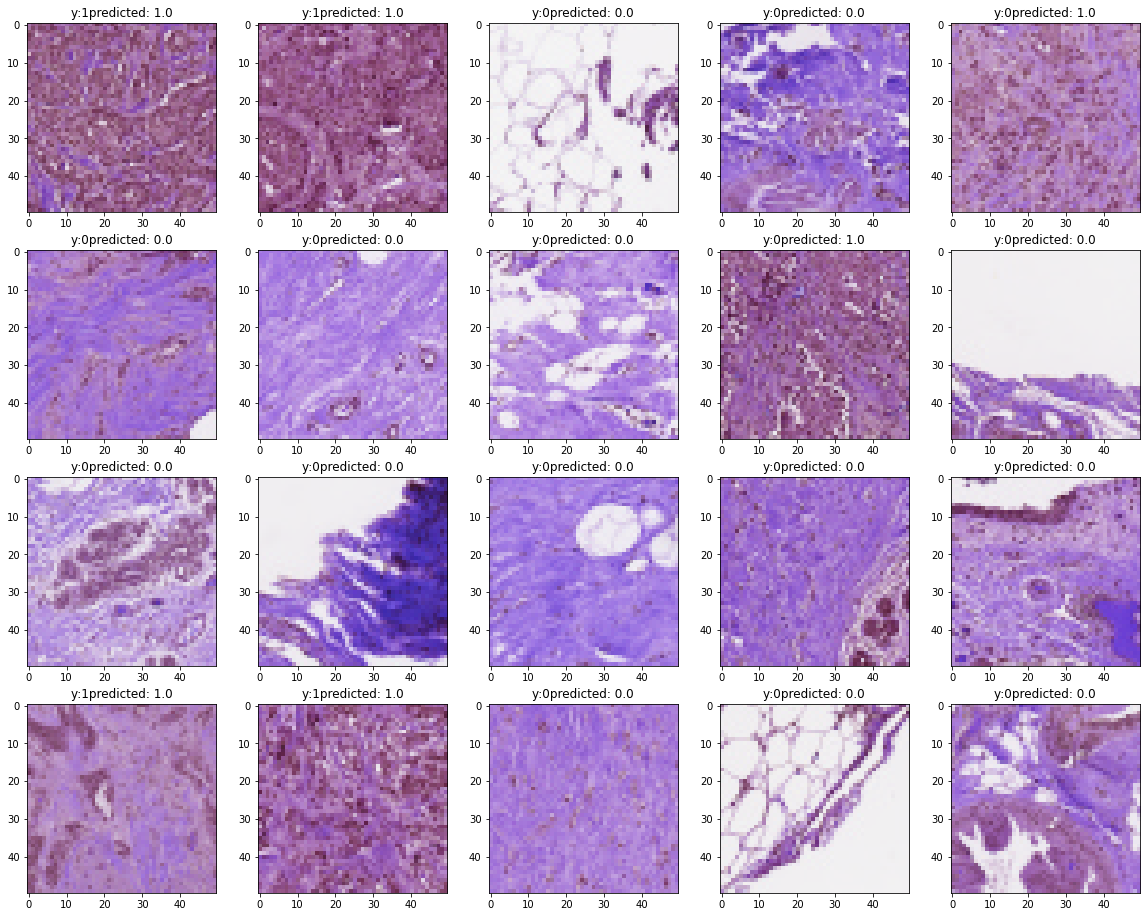

In [49]:
fig = plt.figure(figsize=(20,16))
columns = 5
rows = 4
for i in range(1,columns*rows+1):
    fig.add_subplot(rows,columns,i)
    img = X_test[i]
    plt.title('y:' + str(y_test[i]) + 'predicted: ' + str(y_pred[i]))
    plt.imshow(img, cmap='gray')
plt.show()

Možemo primetiti da je veći broj slika dobro klasifikovan, i da model pravi grešku kod negativnih slika koje zaista izgledaju kao pozitivne, jer su izrazito ljubičaste boje.

In [50]:
FP = X_test[(y_test == 0) & (y_pred == 1)]
FN = X_test[(y_test == 1) & (y_pred == 0)]

In [51]:
print('Broj lazno pozitivnih slika: ', len(FP))
print('Broj lazno negativnih slika: ', len(FN))

Broj lazno pozitivnih slika:  1451
Broj lazno negativnih slika:  626


In [52]:
def plot_img(imgs):
    fig = plt.figure(figsize=(20,12))
    columns = 5
    rows = 4
    for i in range(1,columns*rows+1):
        fig.add_subplot(rows,columns,i)
        img = imgs[i]
        plt.imshow(img, cmap='gray')
    plt.show()

Negativne slike klasifikovane kao pozitivne:


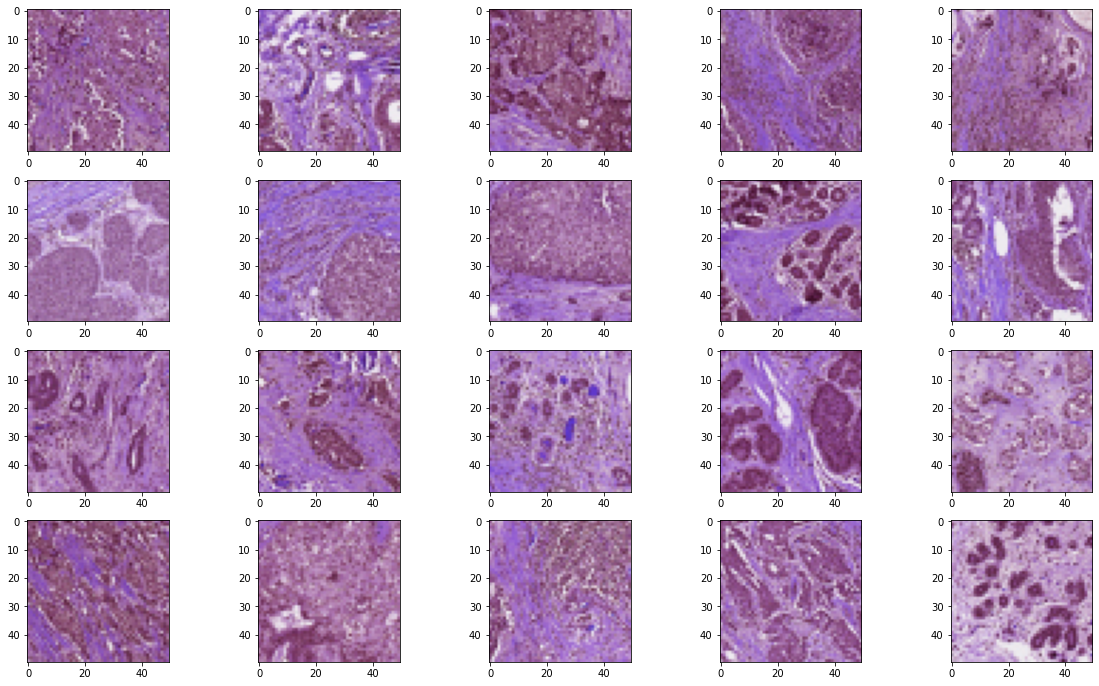

In [53]:
print('Negativne slike klasifikovane kao pozitivne:')
plot_img(FP)

Pozitivne slike klasifikovane kao negativne:


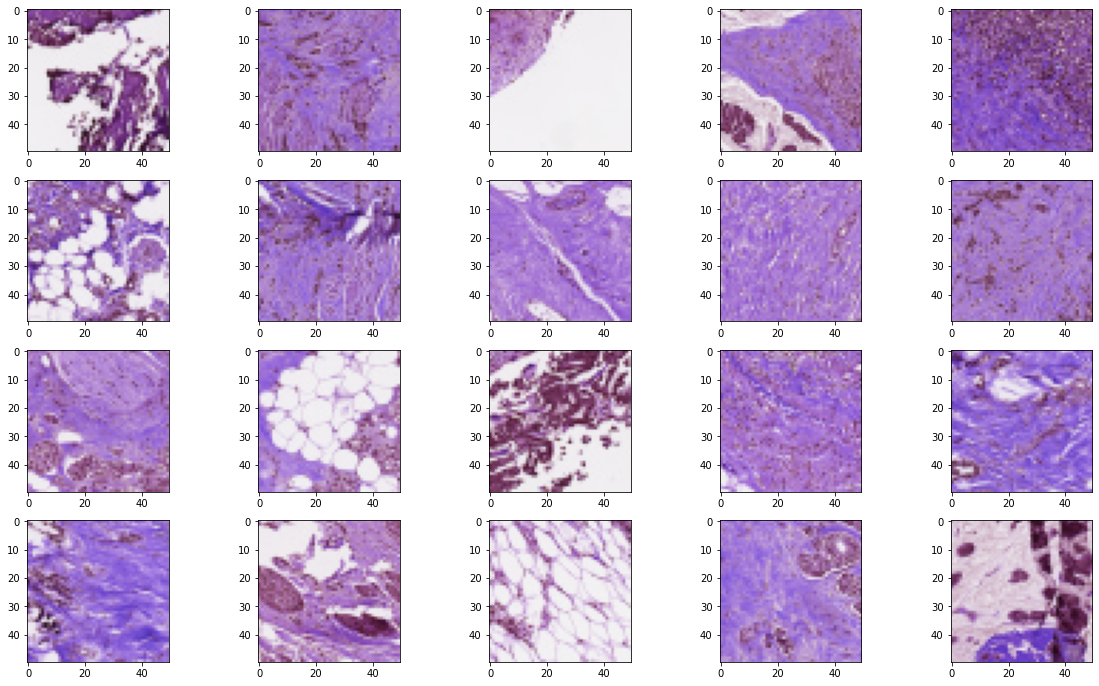

In [54]:
print('Pozitivne slike klasifikovane kao negativne:')
plot_img(FN)

Možemo da primetimo da su slike koje je model pogrešno klasifikovao jako slične. Iako je broj FN dosta manji od FP, što je za nas od velikog značaja, broj FP bi trebalo još smanjiti. Veliki broj loše predviđenih slika je svakako posledica upravo velike sličnosti među određenim pozitivnim i negaticnim slikama, usled čega ne postoji ni jasna granica za njihovo razlikovanje i dobru klasifikaciju.

### Čuvanje modela

In [55]:
model.save('models/cnn.h5')